In [1]:
import easygui
import os
import cv2
import glob
import numpy as np
from numpy.linalg import norm
from moviepy.editor import *
from datetime import datetime
import pandas as pd
pd.options.display.max_columns = 999

## ENV variables ##

In [2]:
def rightnow() -> str:
    return datetime.now().strftime("%Y%m%d_%H%M%S")

In [86]:
INPUT_IMAGE_PATH = '/home/user7/TEST_IMAGE.jpg'
INPUT_IMAGE = cv2.imread('/home/user7/TEST_IMAGE.jpg')
INPUT_AUDIO = AudioFileClip('./TechTalk_001_DRY.mp3')
IMGS_DIR = '/media/user7/Double_Dragon/Videography/My_Apperturelapse/006/'

OUTPUT_DURATION = INPUT_AUDIO.duration
OUTPUT_FPS = 60
OUTPUT_VIDEO_PATH = f'./output_{rightnow()}.mp4'
OUTPUT_VIDEO_PATH

'./output_20230904_191054.mp4'

# Get Image brightness float #

In [87]:
def brightness(img):
    if len(img.shape) == 3:
        # Colored RGB or BGR (*Do Not* use HSV images with this function)
        # create brightness with euclidean norm
        return np.average(norm(img, axis=2)) / np.sqrt(3)
    else:
        # Grayscale
        return np.average(img)
    
brightness(INPUT_IMAGE)

86.9622086852276

## Get Dict {img_path : brightness_value} ##

In [5]:
DIRECTORY :str = easygui.diropenbox(msg="Select a directory", title="Directory Selection", default='/media/user7/Double_Dragon/Videography/My_Apperturelapse')
images_to_process = glob.glob(
    DIRECTORY + "/**/*.JPG", 
    recursive=True
)


print(len(images_to_process), '\n',
        DIRECTORY, '\n', 
)

58 
 /media/user7/Double_Dragon/Videography/My_Apperturelapse/0003 



In [6]:
img_bright_dict = {
    img_path : brightness(cv2.imread(img_path)) for img_path in images_to_process
}

In [7]:
max_brightness = min(img_bright_dict.values())

for k,v in img_bright_dict.items():
    if v == max_brightness:
        print(k)
        break

max_brightness

/media/user7/Double_Dragon/Videography/My_Apperturelapse/0003/P1290257.JPG


2.0074254304344077

<Axes: >

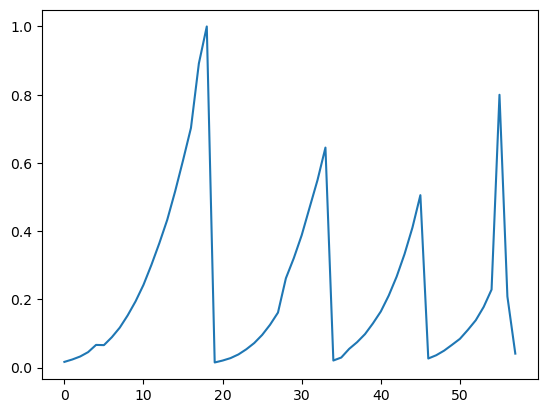

In [8]:
df_000 = pd.DataFrame([(k,v) for k,v in img_bright_dict.items()], columns=['IMG_PATH', 'BRIGHTNESS'])
df_000['BRIGHTNESS_NORMALIZED'] = df_000['BRIGHTNESS'] / df_000['BRIGHTNESS'].max()
df_000.BRIGHTNESS_NORMALIZED.plot.line()

In [88]:
df_000.sample(10)

,IMG_PATH,BRIGHTNESS,BRIGHTNESS_NORMALIZED
33,/media/user7/Double_Dragon/Videography/My_Appe...,87.867927,0.644858
43,/media/user7/Double_Dragon/Videography/My_Appe...,45.339979,0.332748
28,/media/user7/Double_Dragon/Videography/My_Appe...,35.653688,0.261660
48,/media/user7/Double_Dragon/Videography/My_Appe...,6.734558,0.049425
46,/media/user7/Double_Dragon/Videography/My_Appe...,3.593889,0.026375
9,/media/user7/Double_Dragon/Videography/My_Appe...,26.446544,0.194090
42,/media/user7/Double_Dragon/Videography/My_Appe...,36.300498,0.266407
14,/media/user7/Double_Dragon/Videography/My_Appe...,70.394924,0.516624
31,/media/user7/Double_Dragon/Videography/My_Appe...,63.927540,0.469161
37,/media/user7/Double_Dragon/Videography/My_Appe...,10.115558,0.074238


# Get Dict {videoframe_no : Audioframe_Volume} #

In [89]:
# INPUT_AUDIO = AudioFileClip('20230903_get_Brightness/TechTalk_001_DRY.mp3', fps=44100)
import math

help(INPUT_AUDIO.get_frame)

with AudioFileClip('/home/user7/myPython/My_Projects/My_Python_Video_Projects/20230903_get_Brightness/TechTalk_001_DRY.mp3', fps=44100) as INPUT_AUDIO:
    audio_vol_dict = {
        videoframe_no: INPUT_AUDIO.get_frame(videoframe_no / INPUT_AUDIO.fps)[0]
        for videoframe_no 
        # in range(0, INPUT_AUDIO.fps * math.floor(INPUT_AUDIO.duration))
        in range(0, math.floor(INPUT_AUDIO.duration), math.ceil(INPUT_AUDIO.duration / OUTPUT_FPS))
    }

SyntaxError: invalid syntax (147205019.py, line 7)

In [59]:
import pandas as pd

# Create a list of tuples where the first element is the frame number (index) and the second element is the audio volume value
df_001 = pd.DataFrame(
    [(int(frame_no), value) for (frame_no, value) in audio_vol_dict.items()], 
    columns=['VIDEO_FRAME_NO', 'AUDIO_VOLUME'],
    dtype='str'
    )

In [62]:
df_001.AUDIO_VOLUME = df_001.AUDIO_VOLUME.astype('float').abs()
df_001['VIDEO_FRAME_NO'] = df_001.VIDEO_FRAME_NO.astype('int')
df_001['AUDIO_VOLUME_NORMALIZED'] = df_001.AUDIO_VOLUME / df_001.AUDIO_VOLUME.max()
df_001_ = df_001.copy().sort_values(by='AUDIO_VOLUME_NORMALIZED', ascending=True).reset_index(drop=True)
df_001_.head(10)

,VIDEO_FRAME_NO,AUDIO_VOLUME,AUDIO_VOLUME_NORMALIZED
0,241080,0.000000,0.000000
1,226380,0.000031,0.000147
2,698250,0.000122,0.000587
3,535080,0.000122,0.000587
4,416010,0.000244,0.001174
5,441000,0.000244,0.001174
6,220500,0.000305,0.001467
7,345450,0.000366,0.001761
8,0,0.000427,0.002054
9,41895,0.000427,0.002054


In [63]:
images_count = df_000.shape[0]

list0toimagelength = [math.floor(x * images_count / df_001_.shape[0]) for x in range(df_001_.shape[0])]

print(images_count)
print(list0toimagelength[:10])

58
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Match pd.Frame AVolume to Brightness ## 

In [64]:
df_000SORTED = df_000.sort_values(by=['BRIGHTNESS_NORMALIZED']).reset_index(drop=True)
df_000SORTED['BRIGHTNESS_RANK'] = df_000SORTED.index
df_000SORTED.head(10)

,IMG_PATH,BRIGHTNESS,BRIGHTNESS_NORMALIZED,BRIGHTNESS_RANK
0,/media/user7/Double_Dragon/Videography/My_Appe...,2.007425,0.014732,0
1,/media/user7/Double_Dragon/Videography/My_Appe...,2.243658,0.016466,1
2,/media/user7/Double_Dragon/Videography/My_Appe...,2.773634,0.020356,2
3,/media/user7/Double_Dragon/Videography/My_Appe...,2.792097,0.020491,3
4,/media/user7/Double_Dragon/Videography/My_Appe...,3.202793,0.023505,4
5,/media/user7/Double_Dragon/Videography/My_Appe...,3.593889,0.026375,5
6,/media/user7/Double_Dragon/Videography/My_Appe...,3.751210,0.027530,6
7,/media/user7/Double_Dragon/Videography/My_Appe...,3.986865,0.029259,7
8,/media/user7/Double_Dragon/Videography/My_Appe...,4.406994,0.032343,8
9,/media/user7/Double_Dragon/Videography/My_Appe...,4.892795,0.035908,9


In [82]:
df_001_ = df_001.copy()
df_001_['RANK_BY_AUDIO_VOLUME'] = df_001_['AUDIO_VOLUME_NORMALIZED'].rank(method='first').apply(lambda x: math.floor(x)).astype(int)
df_001_ = df_001_.sort_values(by=['AUDIO_VOLUME_NORMALIZED'])
df_001_['zero_to_image_length'] = list0toimagelength
df_001_.head(10)

,VIDEO_FRAME_NO,AUDIO_VOLUME,AUDIO_VOLUME_NORMALIZED,RANK_BY_AUDIO_VOLUME,zero_to_image_length
328,241080,0.000000,0.000000,1,0
308,226380,0.000031,0.000147,2,0
950,698250,0.000122,0.000587,4,0
728,535080,0.000122,0.000587,3,0
566,416010,0.000244,0.001174,5,0
600,441000,0.000244,0.001174,6,0
300,220500,0.000305,0.001467,7,0
470,345450,0.000366,0.001761,8,0
0,0,0.000427,0.002054,9,0
57,41895,0.000427,0.002054,10,0


In [66]:
df_000SORTED.head()


,IMG_PATH,BRIGHTNESS,BRIGHTNESS_NORMALIZED,BRIGHTNESS_RANK
0,/media/user7/Double_Dragon/Videography/My_Appe...,2.007425,0.014732,0
1,/media/user7/Double_Dragon/Videography/My_Appe...,2.243658,0.016466,1
2,/media/user7/Double_Dragon/Videography/My_Appe...,2.773634,0.020356,2
3,/media/user7/Double_Dragon/Videography/My_Appe...,2.792097,0.020491,3
4,/media/user7/Double_Dragon/Videography/My_Appe...,3.202793,0.023505,4


In [67]:
df_x = pd.merge(left=df_001_, right=df_000SORTED, left_on='zero_to_image_length', right_on='BRIGHTNESS_RANK', how='left')


In [78]:
df_x['VIDEO_FRAME_NO']/

8       0.000000
928     0.016667
571     0.033333
417     0.050000
806     0.066667
         ...    
18     15.916667
51     15.933333
41     15.950000
27     15.966667
43     15.983333
Name: VIDEO_FRAME_NO, Length: 960, dtype: float64

In [73]:
df_x.sort_values(by='VIDEO_FRAME_NO', ascending=True, inplace=True)
df_x.head(10)

,VIDEO_FRAME_NO,AUDIO_VOLUME,AUDIO_VOLUME_NORMALIZED,RANK_BY_AUDIO_VOLUME,zero_to_image_length,IMG_PATH,BRIGHTNESS,BRIGHTNESS_NORMALIZED,BRIGHTNESS_RANK
8,0,0.000427,0.002054,9,0,/media/user7/Double_Dragon/Videography/My_Appe...,2.007425,0.014732,0
928,735,0.141907,0.682318,929,56,/media/user7/Double_Dragon/Videography/My_Appe...,121.488270,0.891596,56
571,1470,0.050995,0.245194,572,34,/media/user7/Double_Dragon/Videography/My_Appe...,26.446544,0.194090,34
417,2205,0.032837,0.157887,418,25,/media/user7/Double_Dragon/Videography/My_Appe...,15.015948,0.110201,25
806,2940,0.086945,0.418048,807,48,/media/user7/Double_Dragon/Videography/My_Appe...,63.927540,0.469161,48
872,3675,0.107361,0.516214,873,52,/media/user7/Double_Dragon/Videography/My_Appe...,82.797197,0.607644,52
874,4410,0.107849,0.518562,875,52,/media/user7/Double_Dragon/Videography/My_Appe...,82.797197,0.607644,52
612,5145,0.058685,0.282172,613,36,/media/user7/Double_Dragon/Videography/My_Appe...,28.738004,0.210907,36
57,5880,0.003143,0.015114,58,3,/media/user7/Double_Dragon/Videography/My_Appe...,2.792097,0.020491,3
563,6615,0.049988,0.240352,564,34,/media/user7/Double_Dragon/Videography/My_Appe...,26.446544,0.194090,34


In [81]:
df_x

,VIDEO_FRAME_NO,AUDIO_VOLUME,AUDIO_VOLUME_NORMALIZED,RANK_BY_AUDIO_VOLUME,zero_to_image_length,IMG_PATH,BRIGHTNESS,BRIGHTNESS_NORMALIZED,BRIGHTNESS_RANK
8,0,0.000427,0.002054,9,0,/media/user7/Double_Dragon/Videography/My_Appe...,2.007425,0.014732,0
928,735,0.141907,0.682318,929,56,/media/user7/Double_Dragon/Videography/My_Appe...,121.488270,0.891596,56
571,1470,0.050995,0.245194,572,34,/media/user7/Double_Dragon/Videography/My_Appe...,26.446544,0.194090,34
417,2205,0.032837,0.157887,418,25,/media/user7/Double_Dragon/Videography/My_Appe...,15.015948,0.110201,25
806,2940,0.086945,0.418048,807,48,/media/user7/Double_Dragon/Videography/My_Appe...,63.927540,0.469161,48
...,...,...,...,...,...,...,...,...,...
18,701925,0.001251,0.006016,20,1,/media/user7/Double_Dragon/Videography/My_Appe...,2.243658,0.016466,1
51,702660,0.002991,0.014380,53,3,/media/user7/Double_Dragon/Videography/My_Appe...,2.792097,0.020491,3
41,703395,0.002472,0.011886,42,2,/media/user7/Double_Dragon/Videography/My_Appe...,2.773634,0.020356,2
27,704130,0.001526,0.007337,28,1,/media/user7/Double_Dragon/Videography/My_Appe...,2.243658,0.016466,1


## Make movieclip ##

In [ ]:
videoclip = ImageSequenceClip(df_x.IMG_PATH.to_list(), fps=60)

# audioclip = AudioFileClip("my_audiofile.mp3") # or .ogg, .wav... or a video !

In [ ]:
AudioClip = AudioFileClip('/home/user7/myPython/My_Projects/My_Python_Video_Projects/20230903_get_Brightness/TechTalk_000_WET.mp3', fps=44100)

In [ ]:
videoclip

In [54]:
df_001.VIDEO_FRAME_NO.max()

704865.0

In [55]:
df_001.VIDEO_FRAME_NO.min()

0.0